# Convolution Net

In [1]:
# This network was trained in google colab.  To run in jupyterlab change the path for data lookup to jupyterPath
#from google.colab import drive
#drive.mount('/content/drive')

## Necessary imports

In [ ]:
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

## Grab Image Function

No image flattening like in single layer net

In [ ]:
def grab_image(img_path_base, index, numImages):
    #Desired image dimension (image will be square i.e. # by # pixels)
    imageDim = 100
    
    if (index<10):
        img_path = img_path_base+"000"+str(index)+"_model.png"
    elif (index<100 and index >=10):
        img_path = img_path_base+"00"+str(index)+"_model.png"
    elif (index<1000 and index>=100):
        img_path = img_path_base+"0"+str(index)+"_model.png"
    elif (index<10000 and index>=1000):
        img_path = img_path_base+str(index)+"_model.png"
        
    img = image.load_img(img_path, target_size=(imageDim, imageDim), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

#Num of images to read in
googleImagePath = '/content/drive/My Drive/Colab Notebooks/Demo/miscImgs/'
googleScoresPath = '/content/drive/My Drive/Colab Notebooks/Demo/miscImgs/scores/humanScores.txt'

jupyterImagePath = 'S20-team2-project/miscImgs'
jupyterScoresPath = 'S20-team2-project/miscImgs/scores/humanScores.txt'

numImages = 1000
X = np.concatenate([grab_image(googleImagePath,i, numImages) for i in range(numImages)]) 
X /= 255.0

X.shape

(1000, 100, 100, 1)

## Check an image to make sure it was read in right

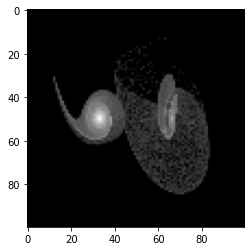

In [ ]:
plt.imshow(image.array_to_img(X[45,:,:,:]), cmap='Greys_r')
plt.show()

## Load in model scores

In [ ]:
Y = np.loadtxt(googleScoresPath)
Y=Y[0:numImages]
display(Y[0:10])
display(Y.shape)

array([0.945946, 0.941176, 0.918919, 0.916667, 0.916667, 0.914286,
       0.914286, 0.911765, 0.891892, 0.885714])

(1000,)

## Shuffle model images and scores

In [ ]:
p = np.random.permutation(len(X))
Xshuffled = X[p]
Yshuffled = Y[p]

display(Xshuffled.shape)
display(Yshuffled.shape)

(1000, 100, 100, 1)

(1000,)

## Show image and score to verify that they were shuffled with link between model and corresponding score intact

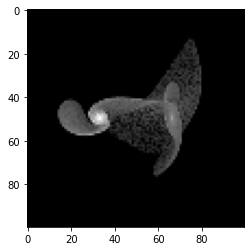

0.558824

In [ ]:
plt.imshow(image.array_to_img(Xshuffled[0,:,:,:]), cmap='Greys_r')
plt.show()
display(Yshuffled[0])

## Split into training and test data (85% for training and validation)

In [ ]:
x_train = Xshuffled[0:(round(numImages*.85)),:,:]
y_train = Yshuffled[0:(round(numImages*.85))]
x_test = Xshuffled[(round(numImages*.85)): , : , :]
y_test = Yshuffled[(round(numImages*.85)):]

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(850, 100, 100, 1)

(850,)

(150, 100, 100, 1)

(150,)

## Build net and generate image of architecture
In order for the model to learn the images correctly it must be able to detect both the models that fail to form the bridge feature as well as the models that form wild distortions that appear in the perifery of the image.  To facilitate this:
- 12x12 filters is used as this would capture the center of the bridge.
- This is followed by 8x8 filters in order to capture fine details.
  - This appears to be most useful in detecting which areas should likely have any feature at all or none at all.
- No padding is used in this block as the model trains better when allowed to throw away the the overrun.
- In block two the filters are sized such that they fit the bounds of the image perfectly.
- This block is ment to train the model on more fine details.
  - Without this block the model has difficulty distinguishing between the differen qualityies of images contain a bridge.
  - This improves its preformance when given chaotic collisions that have a bridge.

In [ ]:
model = keras.Sequential()
# Block One
model.add(keras.layers.Conv2D(filters=16,
                              kernel_size=(12, 12),
                              activation='relu',
                              input_shape=[x_test.shape[1],
                                           x_test.shape[2],
                                           x_test.shape[3]
                                           ]
                              ))
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=(8, 8), 
                              activation='relu'
                              ))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.5))

# Block Two
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=(10, 10),
                              activation='relu',
                              input_shape=[x_test.shape[1],
                                           x_test.shape[2],
                                           x_test.shape[3]
                                           ]
                              ))
model.add(keras.layers.Conv2D(filters=64,
                              kernel_size=(5, 5), 
                              activation='relu'
                              ))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.5))

# Flatten and Generate Output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=32,
                             activation='relu'
                             ))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1,
                             activation=keras.activations.sigmoid
                             ))

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['mse']
              )
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 89, 89, 16)        2320      
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 82, 82, 32)        32800     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 41, 41, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 32)        102432    
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 64)      

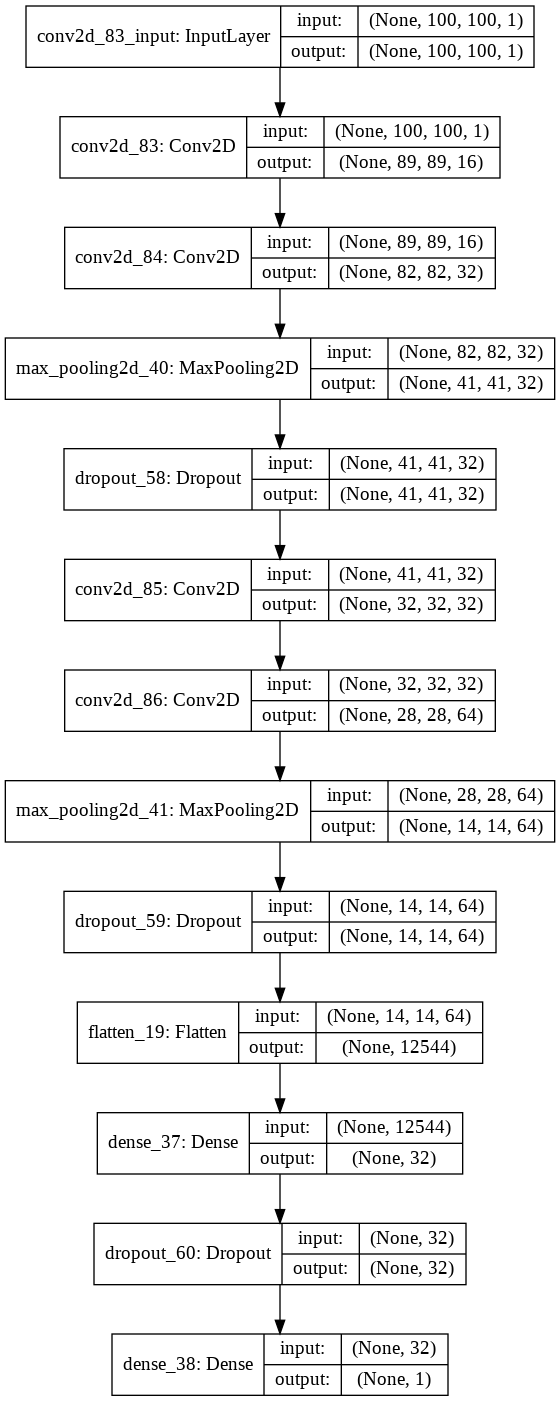

In [ ]:
plot_model(model,to_file='convNet.png',show_shapes=True,expand_nested=True)

## Train it

In [ ]:
# This permutation of the model aggressivly overfits
#   after ~530 epochs.  So training is stopped just
#   before that point.
batch_size = 32
epochs = 500
history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=[x_test, 
                                     y_test
                                     ]
                    )

Train on 850 samples, validate on 150 samples
Epoch 1/500
850/850 [==============================] - 1s 763us/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 2/500
850/850 [==============================] - 0s 437us/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 3/500
850/850 [==============================] - 0s 433us/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 4/500
850/850 [==============================] - 0s 446us/step - loss: 0.0504 - mse: 0.0504 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 5/500
850/850 [==============================] - 0s 451us/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 6/500
850/850 [==============================] - 0s 438us/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 7/500
850/850 [==============================] - 0s 449us/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 8/5

## Generate loss (MSE) plot

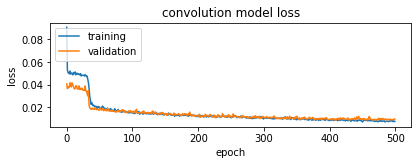

In [ ]:
plt.figure()
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('convolution model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("ConvModelLoss.png")
plt.show()

## Test on remaining 90 images and calculate mean difference between predicted and actual scores

In [ ]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.06889501530570666

## Save model

In [ ]:
model.save("atm4wCurModel")

## Various data plots

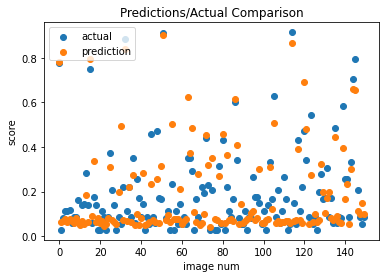

<Figure size 14400x1440 with 0 Axes>

In [ ]:

shuffledInd = np.linspace(0,149,num = 150)

plt.figure()
plt.scatter(shuffledInd, y_test)
plt.scatter(shuffledInd, preds)
plt.title("Predictions/Actual Comparison")
plt.ylabel("score")
plt.xlabel("image num")
plt.legend(['actual', 'prediction'], loc='upper left')
plt.figure(figsize=(200,20))
plt.show()

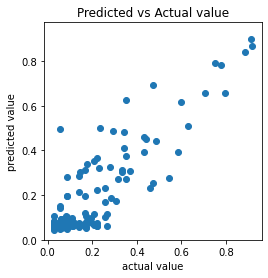

In [ ]:
plt.figure()
plt.scatter(y_test, preds)
plt.title("Predicted vs Actual value")
plt.ylabel("predicted value")
plt.xlabel("actual value")
plt.savefig("ConvPredictedVAct.png")
plt.axis('square')
plt.show()

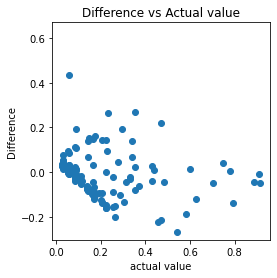

In [ ]:
plt.figure()
plt.scatter(y_test, diff)
plt.title("Difference vs Actual value")
plt.ylabel("Difference")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("ConvDiffVAct.png")
plt.show()

## Find the 10 worst and 5 best predictions

In [ ]:
absDiff = np.abs(diff)

top10 = np.argpartition(absDiff, -10)[-10:]
bottom5= np.argpartition(absDiff, 5)[:5]
display(top10)
display(bottom5)

array([ 65, 110,  55,  45,  30,  48, 123,  68, 120,  63])

array([108,  90,  60,  93,  34])

## Show the 10 worst predictions

In [ ]:
for i in range (10):
    print("Human Score")
    display(y_test[top10[i]])
    print("Prediction")
    display(preds[top10[i]][0])
    print("---------------")

Human Score


0.294118

Prediction


0.48557183

---------------
Human Score


0.264706

Prediction


0.062143095

---------------
Human Score


0.235294

Prediction


0.50180894

---------------
Human Score


0.457143

Prediction


0.23242766

---------------
Human Score


0.057143

Prediction


0.49395928

---------------
Human Score


0.470588

Prediction


0.25468254

---------------
Human Score


0.542857

Prediction


0.27474698

---------------
Human Score


0.088235

Prediction


0.28067064

---------------
Human Score


0.470588

Prediction


0.6918239

---------------
Human Score


0.352941

Prediction


0.6243114

---------------


## Show the 10 models that had the largest difference between predicted and human score

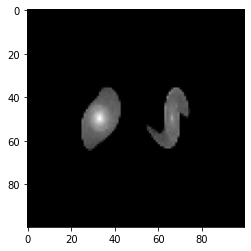

Human Score


0.294118

Prediction


0.48557183

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[0],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[0]])
print("Prediction")
display(preds[top10[0]][0])

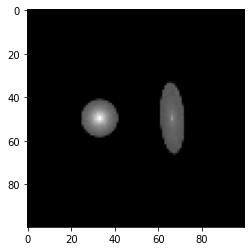

Human Score


0.264706

Prediction


0.062143095

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[1],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[1]])
print("Prediction")
display(preds[top10[1]][0])

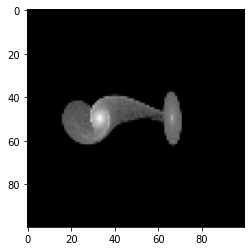

Human Score


0.235294

Prediction


0.50180894

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[2],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvHumanNoiseExample2.png")
plt.show()

print("Human Score")
display(y_test[top10[2]])
print("Prediction")
display(preds[top10[2]][0])

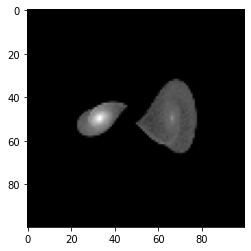

Human Score


0.457143

Prediction


0.23242766

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[3],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[3]])
print("Prediction")
display(preds[top10[3]][0])

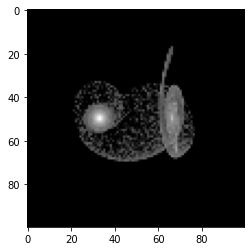

Human Score


0.057143

Prediction


0.49395928

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[4],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[4]])
print("Prediction")
display(preds[top10[4]][0])

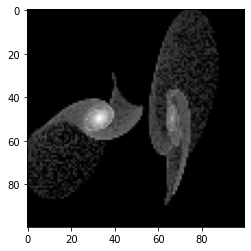

Human Score


0.470588

Prediction


0.25468254

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[5],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[5]])
print("Prediction")
display(preds[top10[5]][0])

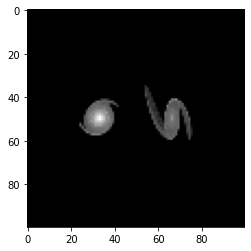

Human Score


0.542857

Prediction


0.27474698

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[6],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[6]])
print("Prediction")
display(preds[top10[6]][0])

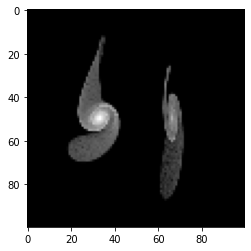

Human Score


0.088235

Prediction


0.28067064

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[7],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[7]])
print("Prediction")
display(preds[top10[7]][0])

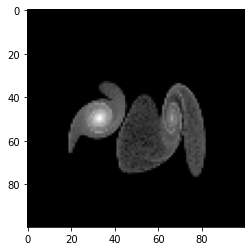

Human Score


0.470588

Prediction


0.6918239

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[8],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[8]])
print("Prediction")
display(preds[top10[8]][0])

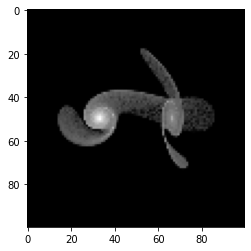

Human Score


0.352941

Prediction


0.6243114

In [ ]:
plt.imshow(image.array_to_img(x_test[top10[9],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvHumanNoiseExample.png")
plt.show()

print("Human Score")
display(y_test[top10[9]])
print("Prediction")
display(preds[top10[9]][0])

## Show the 5 models that the net had the closest prediction on

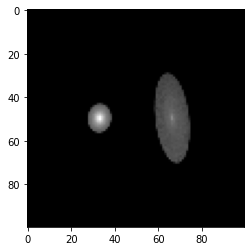

Human Score


0.058824

Prediction


0.059968013

In [ ]:
plt.imshow(image.array_to_img(x_test[bottom5[0],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[bottom5[0]])
print("Prediction")
display(preds[bottom5[0]][0])

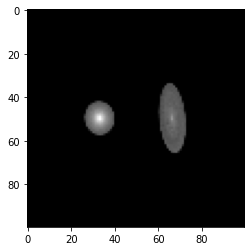

Human Score


0.057143

Prediction


0.05805636

In [ ]:
plt.imshow(image.array_to_img(x_test[bottom5[1],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[bottom5[1]])
print("Prediction")
display(preds[bottom5[1]][0])

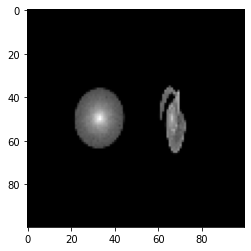

Human Score


0.057143

Prediction


0.05598427

In [ ]:
plt.imshow(image.array_to_img(x_test[bottom5[2],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[bottom5[2]])
print("Prediction")
display(preds[bottom5[2]][0])

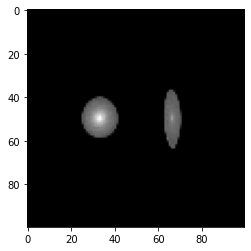

Human Score


0.085714

Prediction


0.084173456

In [ ]:
plt.imshow(image.array_to_img(x_test[bottom5[3],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[bottom5[3]])
print("Prediction")
display(preds[bottom5[3]][0])

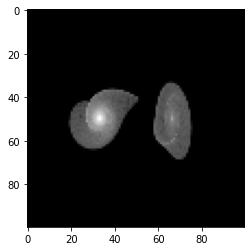

Human Score


0.222222

Prediction


0.2204854

In [ ]:
plt.imshow(image.array_to_img(x_test[bottom5[4],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[bottom5[4]])
print("Prediction")
display(preds[bottom5[4]][0])

In [ ]:
maxPred = np.amax(preds, axis=0)
maxPredIndex = np.where(preds == maxPred)
display(maxPred[0])
display(maxPredIndex[0][0])

0.901352

51

## Show the model that the net gave the highest score

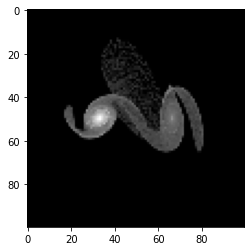

Human Score


0.911765

Prediction


0.901352

In [ ]:
plt.imshow(image.array_to_img(x_test[maxPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[maxPredIndex[0][0]])
print("Prediction")
display(preds[maxPredIndex[0][0]][0])